<a href="https://colab.research.google.com/github/MosaabMuhammed/GNN-Tasks/blob/main/Graph_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Classification

The goal of graph classification is to classify an entire graph instead of single nodes or edges. Therefore, we are also given a dataset of multiple graphs that we need to classify based on some structural graph properties.

The most common task for graph classification is molecular property prediction, in which molcules are represented as graphs.

Each atom is lined to a node, and edges in the graph are the bonds between atoms.

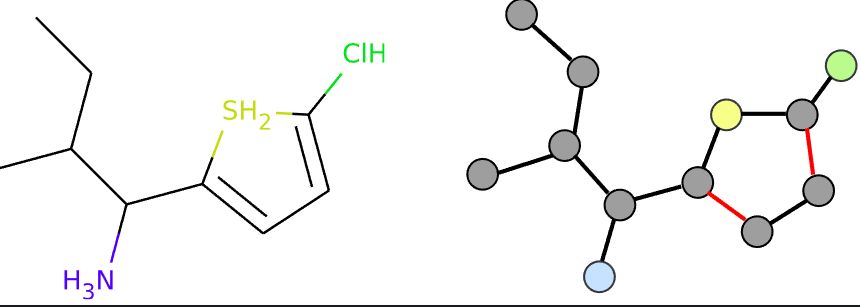

On the left, we have an arbitrary, small molecule with different atoms, whereas the right part of the image shows the graph representation. The atom types are abstracted as node features (e.g. a one-hot vector), and the different bond types are used as edge features.

The work in this notebook we rely on:
- PyTorch
- PyTorch Geometric
- PyTorch Lightning

## Imports

In [1]:
import os
import json
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## progress bar
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# TorchVision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

DATASET_PATH  = "/content/dataset"
CHECKPOINT_PATH = "/content/checkpoints"

# Setting the seed.
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducability
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


cpu


In this notebook, I will be using `PyTorch Geometric` as part of the PyTorch family.

In [8]:
try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version.
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details
    TORCH = torch.__version__.split("+")[0]
    CUDA  = 'cu' + torch.version.cuda.replace('.', '')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric
    import torch_geometric

import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

`PyTorch Geometric` provides a set of common graph layers, including the GCN, GAT and GraphConv layers. <br>
It also provides the common graph datasets and transformations on those to simplify training. <br>
It uses a list of index pairs to represent the edges.

Since I will be using 3 different graph layers, I will create a dictionary to select any one of them easily.

In [3]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

## Dataset

The dataset we will use below is called the MUTAG dataset. It is a common small benchmark for graph classification algorithms, and contain 188 graphs with 18 nodes and 20 edges on average for each graph.

The graph nodes have 7 different labels/atom types, and the binary graph labels represent “their mutagenic effect on a specific gram negative bacterium” (the specific meaning of the labels are not too important here).

The dataset is part of a large collection of different graph classification datasets, known as the TUDatasets, which is directly accessible via `torch_geometric.datasets.TUDataset` in PyTorch Geometric.

We can load the dataset below.

In [4]:
tu_dataset = torch_geometric.datasets.TUDataset(root=DATASET_PATH, name="MUTAG")

Extracting /content/dataset/MUTAG/MUTAG.zip
Processing...
Done!


Let’s look at some statistics for the dataset:

In [5]:
print("Data object:", tu_dataset.data)
print("Length:", len(tu_dataset))
print(f"Average label: {tu_dataset.data.y.float().mean().item():4.2f}")

Data object: Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
Length: 188
Average label: 0.66


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


The first line shows how the dataset stores different graphs. The nodes, edges, and labels of each graph are concatenated to one tensor, and the dataset stores the indices where to split the tensors correspondingly.

- edge_attr=[7442, 4]: This indicates that there are 7442 edges in the graph, and each edge has 4 attributes. Edge attributes are additional features associated with the edges of the graph.
- edge_index=[2, 7442]: This shows the indices of the nodes that are connected by each edge. The first row contains the indices of the source nodes, and the second row contains the indices of the target nodes.
- x=[3371, 7]: This shows the node features for each of the 3371 nodes in the graph. Each node has 7 features.
- y=[188]: This shows the target label for the graph. In this case, there is only one label, which means that the graph is associated with a binary classification task (i.e., predicting one of two possible outcomes).

The length of the dataset is the number of graphs we have, and the “average label” denotes the percentage of the graph with label 1. As long as the percentage is in the range of 0.5, we have a relatively balanced dataset. It happens quite often that graph datasets are very imbalanced, hence checking the class balance is always a good thing to do.

## Split

In [6]:
torch.manual_seed(42)
tu_dataset.shuffle()
train_dataset = tu_dataset[:150]
test_dataset  = tu_dataset[150:]

When using a data loader, we encounter a problem with batching N graphs.
Each graph in the batch can have a different number of nodes and edges, and hence we would require a lot of padding to obtain a single tensor.

Torch geometric uses a different, more efficient approach: we can view the N graphs in a batch as a single large graph with concatenated node and edge list.

As there is no edge between the N graphs, running GNN layes on the large graph gives us the same output as running the GNN on edge graph separately.

Luckily, this strategy is already implemented in torch geometric, and hence we can use the corresponding data loader:

In [9]:
graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=64, shuffle=True)
graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=64) # Additional loader if you want to change to a larger dataset
graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Let’s load a batch below to see the batching in action:

In [10]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(edge_index=[2, 1512], x=[687, 7], edge_attr=[1512, 4], y=[38], batch=[687], ptr=[39])
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])


We have 38 graphs stacked together for the test dataset.

The batch indices, stored in `batch`, show that the first 12 nodes belong to the first graph, the next 22 to the second graph, and so on.

These indices are important for performing the final prediction. To perform a prediction over a whole graph, we usually perform a pooling operation over all nodes after  running the GNN model.

In this case, we will use the average pooling. Hence, we need to know which nodes should be included in which average pool. Using this pooling, we can already create our graph network below.

## Model

After having seen the data, we can implement a simple graph neural network.

The GNN applies a sequence of graph layers (GCN, GAT, or GraphConv), ReLU as activation function, and dropout for regularization.

In [20]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [19]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden,  # Not our prediction output yet.
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges
            batch_idx  - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average Pooling
        x = self.head(x)
        return x


Finally, we can merge the models into a PyTorch Lightning module which handles the training, validation, and testing for us out-of-the-box.

In [21]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0) # Higher lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

Additionally to the Lightning module, we define a training function below.

Besides, we set the argument `enable_progress_bar` to False as it usually shows the progress per epoch, but an epoch only consists of a single step.

In [25]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning Trainer with teh generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=500,
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=tu_dataset.num_node_features,
                              c_out=1 if tu_dataset.num_classes==2 else tu_dataset.num_classes,
                              **model_kwargs)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, graph_train_loader, verbose=False)
    test_result  = trainer.test(model, graph_test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'],
              "train": train_result[0]['test_acc']}

    return model, result

Finally, we can train our models. First let's train the simple MLP.

In [26]:
# Small function for printing the test scores.
def print_results(result_dict):
    if "train" in result_dict:
        print(f"Train accuracy: {(100.0 * result_dict['train']):4.2f}%")
    if "val" in result_dict:
        print(f"Val accuracy: {(100.0 * result_dict['val']):4.2f}")
    print(f"Test accuracy: {(100.0 * result_dict['test']):4.2f}%")

In [27]:
model, result = train_graph_classifier(model_name="GraphConv",
                                        layer_name="GraphConv",
                                        c_hidden=256,
                                         num_layers=3,
                                        dp_rate_linear=0.5,
                                        dp_rate=0.0)
print("-"*20)
print_results(result)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 266 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.067     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


--------------------
Train accuracy: 92.28%
Test accuracy: 89.47%


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


The test performance shows that we obtain quite good scores on an unseen part of the dataset.

It should be noted that as we have been using the test set for validation as well, we might have overfitted slightly to this set. Nevertheless, the experiment shows us that GNNs can be indeed powerful to predict the properties of graphs and/or molecules